# Observability Starter for Anthropic Claude model

This accelerator shows how you can easily enable observability in your <a href='https://www.anthropic.com/'>Anthropic AI</a> based Generative AI Solutions with DataRobot's LLMOps feature tools. It outlines an example of a byte-sized solution in its current state and then uses DataRobot tools to enable observability almost instantly for the solution.

DataRobot provides tools to enable the observability of external generative models. All the hallmarks of DataRobot MLOps are now available for LLMOps.

## Setup

### Install the prerequisite libraries

This notebook will be using Anthropic's most powerful LLM <a href='https://www.anthropic.com/index/claude-2'>Claude v2</a> available via AWS. It uses the recommended installation files instead of PyPi as per the AWS official <a href='https://d2eo22ngex1n9g.cloudfront.net/Documentation/BedrockUserGuide.pdf'>Bedrock documentation</a>. You can use the newer methods of installation if AWS updates the documentation at the time of running this notebook.

If the user intends to use Claude v2 provided by other platforms, the notebook can still be utilized with minor refactoring.

In [ ]:
!mkdir storage/bedrock_sdk/
import shutil

import requests

url = "https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk.zip"
r = requests.get(url, allow_redirects=True)
open("storage/bedrock-python-sdk.zip", "wb").write(r.content)
shutil.unpack_archive("storage/bedrock-python-sdk.zip", "storage/bedrock_sdk/")
!pip install storage/bedrock_sdk/botocore-1.31.21-py3-none-any.whl storage/bedrock_sdk/boto3-1.28.21-py3-none-any.whl

In [ ]:
!pip install datarobotx[llm] datarobot-mlops datarobot-mlops-connected-client transformers "langchain==0.0.335"

In [ ]:
!pip install py-readability-metrics nltk

## Current state 

The following cells outline the current state of a simple <a href='https://www.anthropic.com/index/claude-2'>Claude v2</a> text generation model implementation. Claude v2 is Anthropic's most powerful foundational model as of the time this notebook is written. AWS provides other Anthropic models like Claude v1.3 and Claude Instant which can also be used in this notebook by updating the `modelId` parameter.

Use the Claude v2 model to generate text. The `get_completion` endpoint is used to generate text based on the input prompt. To enable observability on this implementation on your own, you would have to write code to take measurements, enable infrastructure to record all the measurements, and codify rules for interventions. This also introduces a lot of technical debt in the organization. 
<br>
<br>

In [ ]:
import json
import os

import boto3

ACCESS_KEY = os.environ["ACCESS_KEY"]
SECRET_KEY = os.environ["SECRET_KEY"]
SESSION_TOKEN = os.environ["SESSION_TOKEN"]

bedrock = boto3.client(
    "bedrock",
    "us-west-2",
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN,
)

prompt_data = """
You are an education expert. Please explain the following concept to me as if I am a \
5 year old with examples: """

parameters = {
    # "stopSequences":[],
    "max_tokens_to_sample": 300,
    "temperature": 0,
    "top_p": 0.999,
    "top_k": 250,
}

modelId = "anthropic.claude-v2"
accept = "*/*"
contentType = "application/json"


def get_completion(user_input, parameters):
    body = json.dumps({**{"prompt": prompt_data + user_input}, **parameters})
    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    answer = json.loads(response.get("body").read())
    return answer


outputText = get_completion("Agile", parameters)
print(outputText.get("completion"))

 learning
Here is a simple explanation of agile learning for a 5 year old:
Agile learning is about being flexible and adaptable when you learn new things. It's kind of like when you play with blocks. You start by building one thing, like a tower. But then you decide to change it and build something else, like a bridge. With agile learning, you don't just stick to one plan, you try new ideas and change course if needed. 
For example, let's say you are learning to ride a bike. At first, you use training wheels which help you balance. But then when you get better, you take the training wheels off to ride on just two wheels. This is agile because you changed your approach as you learned new skills. 
Or let's say you are learning addition in school. Your teacher first teaches you to add small numbers using your fingers to count. But once you master that, you move on to adding bigger numbers using paper and pencil. This is agile too because you didn't just keep counting on your fingers, you 

## Observability with DataRobot
To enable observability on the above Claude model from AWS, you first need to create a deployment in DataRobot. This can be done from the GUI or the API based on your preference.

### Connect to DataRobot

In [ ]:
# Initialize the DataRobot Client if you are not running this code outside DataRobot platform.
# import datarobot as dr
# dr.Client(endpoint=ENDPOINT,token=TOKEN)

In [ ]:
from utilities import create_external_llm_deployment

deployment_id, model_id = create_external_llm_deployment(modelId + " External")
deployment_id

[nltk_data] Downloading package punkt to /home/notebooks/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'650964628c6ad4b7b69f6bcb'

### Initiate monitoring configuration

The cells below declare and initialize monitoring configuration. The monitoring configuration lets DataRobot understand how to interpret the inputs and outputs of the external model. Standard implementation of the hosted Claude object has a <a href='https://docs.aws.amazon.com/bedrock/latest/APIReference/API_InvokeModel.html'>invoke_model</a> endpoint which expects prompt text and json parameters which are configured in the MonitoringConfig object as seen below. 

The <a href="https://drx.datarobot.com/reference/_autosummary/datarobotx.llm.MonitoringConfig.html#monitoringconfig">input_parser</a> object is helpful in capturing and storing the entire input or just the essential parts that you prefer.

In [ ]:
from datarobotx.llm.chains.guard import aguard, MonitoringConfig

monitor_config = MonitoringConfig(
    deployment_id=deployment_id,
    model_id=model_id,
    inputs_parser=lambda prompt, parameters: {**{"prompt": prompt}, **parameters},
    output_parser=lambda x: {"answer": x.get("completion")},
    target="answer",
)

In [ ]:
@aguard(monitor_config)
async def get_completion(user_input, parameters):
    body = json.dumps({**{"prompt": prompt_data + user_input}, **parameters})
    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    answer = json.loads(response.get("body").read())
    return answer


answer = await get_completion("Agile", parameters)
print(answer.get("completion"))

 learning.
Here is a simple explanation of agile learning for a 5 year old:
Agile learning is about being flexible and adaptable when you learn new things. It's kind of like when you play a sport - you have to be quick on your feet and ready to change what you're doing based on what's happening in the game. 
With agile learning, your teacher doesn't give you a big textbook and tell you to read the whole thing. Instead, you learn a little bit at a time, in small chunks. It's more hands-on and you get to try out new skills right away instead of just reading about them. 
For example, let's say you're learning to bake. With agile learning, your teacher wouldn't start by making you read a long textbook about baking. Instead, you would start by making something simple, like cookies. As you bake the cookies, the teacher guides you and gives you tips. When you're done, you can eat the cookies! Then for the next lesson, you build on what you learned and try baking something a little harder, lik

## Custom metrics

Observability with DataRobot also supports <a href='https://docs.datarobot.com/en/docs/mlops/deployment-settings/custom-metrics-settings.html'>custom user metrics</a>. The following cells show how you can start capturing toxicity in user prompts and readability in generative model responses. Add the custom metrics in the cell below that you want to record to your deployment. Again, this step can be done using the GUI or the API based on user preference. <br>
- Toxicity in the user prompt <br>
- Readability (Flesch Score) of the model response 

In [ ]:
from utilities import create_custom_metric

TOX_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Prompt Toxicity",
    baseline="0.1",
    type="average",
    directionality="lowerIsBetter",
)

READ_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Response Readability",
    baseline="30",
    type="average",
    directionality="higherIsBetter",
)

### Update the Claude completion endpoint

Modify the prediction function to add code that calculates the metrics and submits them to the deployment. Now, whenever the prediction is requested from the Claude v2 model, the metrics are calculated and submitted on the deployment enabling you to monitor and intervene as necessary.

In [ ]:
from utilities import get_flesch_score, get_text_texicity, submit_custom_metric


@aguard(monitor_config)
async def get_completion(user_input, parameters):
    body = json.dumps({**{"prompt": prompt_data + user_input}, **parameters})
    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    answer = json.loads(response.get("body").read())
    try:
        submit_custom_metric(
            deployment_id,
            READ_CUSTOM_METRIC_ID,
            get_flesch_score(answer.get("completion")),
        )
        submit_custom_metric(deployment_id, TOX_CUSTOM_METRIC_ID, get_text_texicity(user_input))
    except Exception as e:
        print(e)
        pass
    return answer


answer = await get_completion("Agile", parameters)
print(answer.get("completion"))

 learning.
Here is a simple explanation of agile learning for a 5 year old:
Agile learning is about being flexible and adaptable when you learn new things. It's kind of like when you play a sport - you have to be quick on your feet and ready to change what you're doing based on what's happening in the game. 
With agile learning, your teacher doesn't give you a big textbook and tell you to read the whole thing. Instead, you learn a little bit at a time, in small chunks. It's more hands-on and you get to try out new skills right away instead of just reading about them. 
For example, let's say you're learning to bake. With agile learning, your teacher wouldn't start by making you read a long textbook about baking. Instead, you would start by making something simple, like cookies. As you bake the cookies, the teacher guides you and gives you tips. When you're done, you can eat the cookies! Then for the next lesson, you build on what you learned and try baking something a little harder, lik

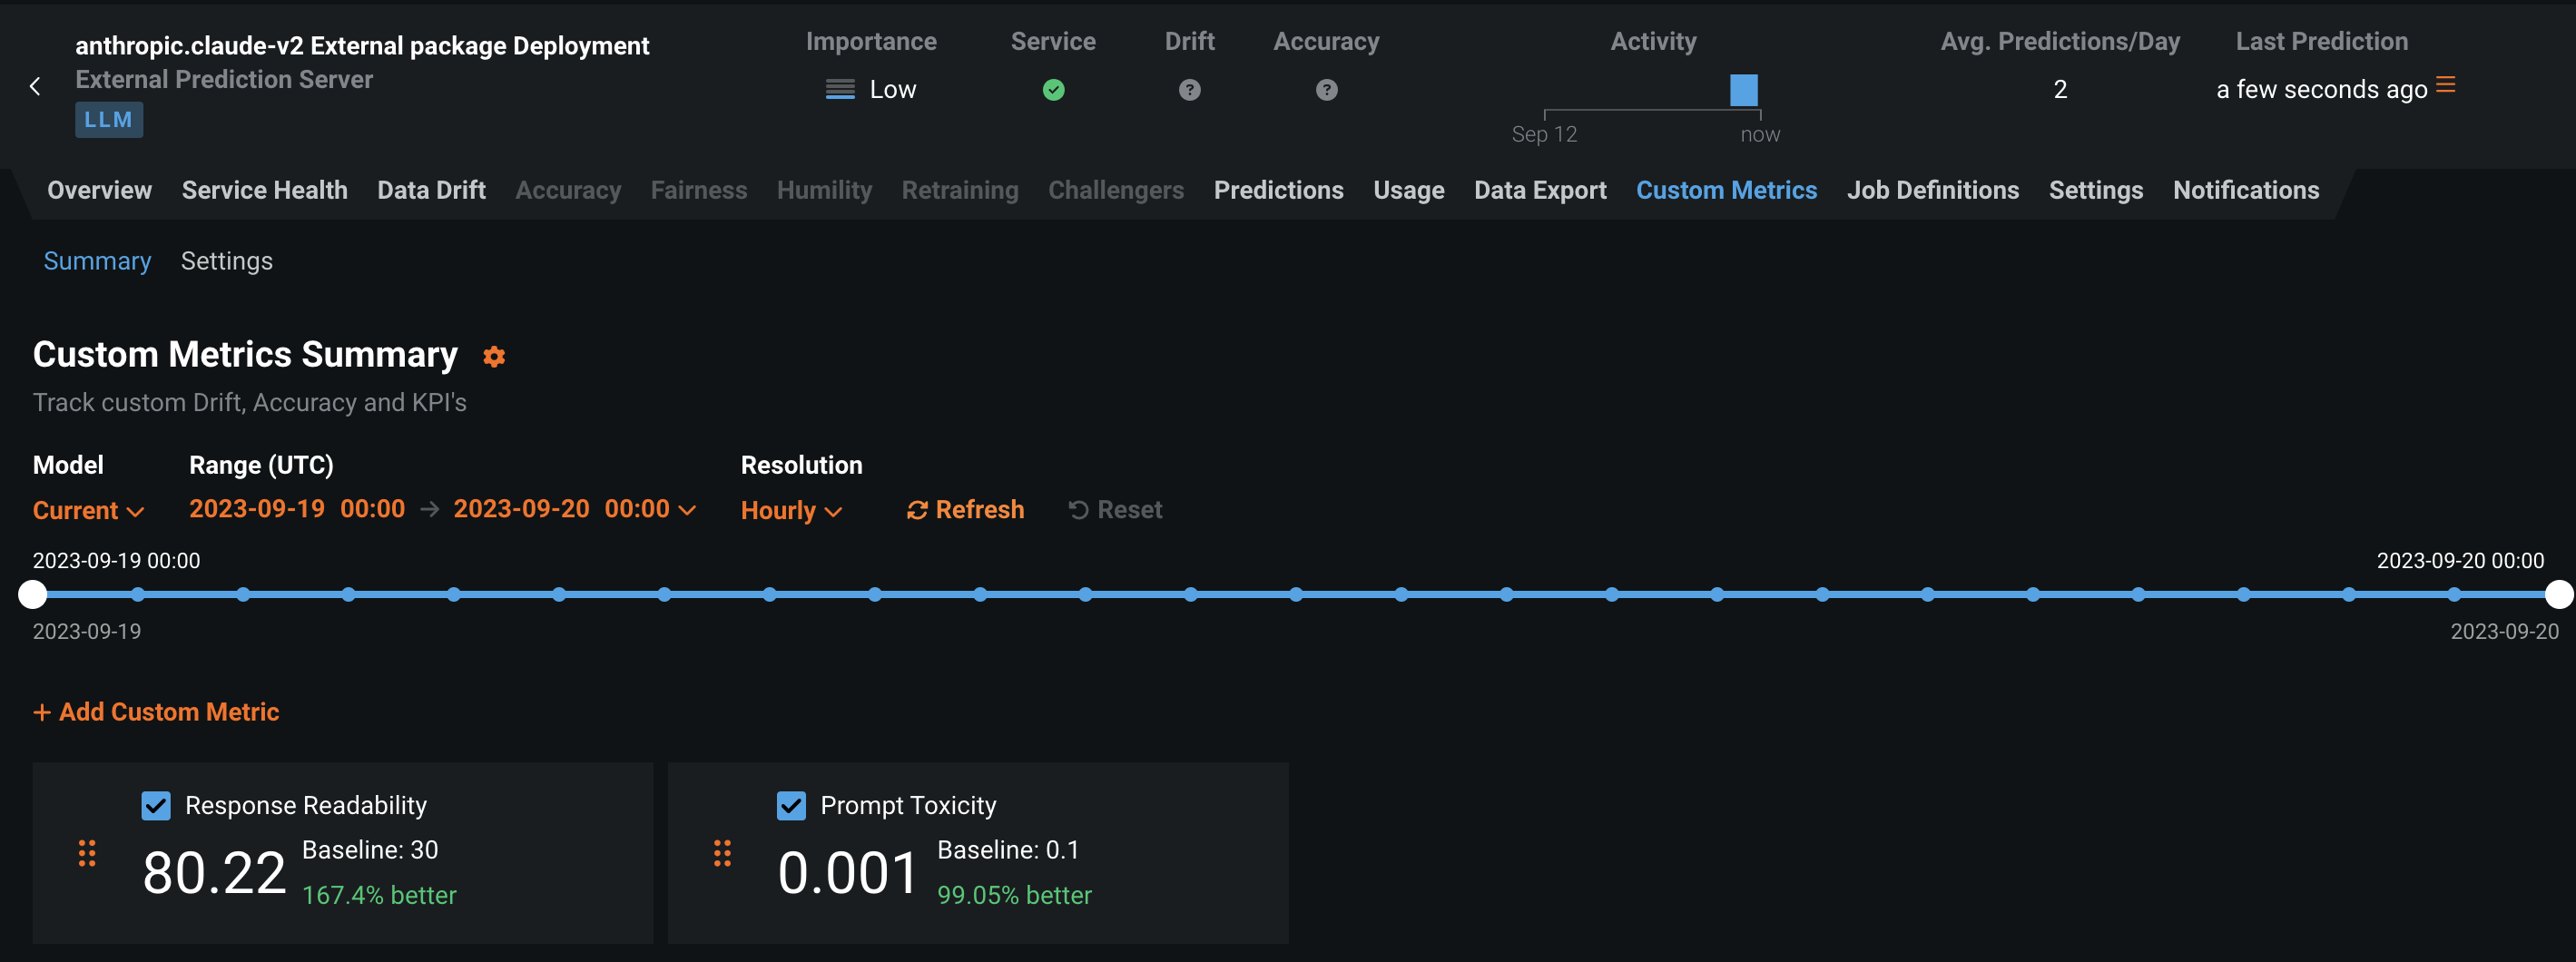

## Conclusion

Using DataRobot's tools for LLMOps, you can implement observability for Anthropic's Claude v2 based applications easily with easily with less friction while avoiding increased technical debt.